In [3]:
# Examine SBGC results
from netCDF4 import Dataset as NetCDFFile
import math
import numpy as np
import isamcalc_lib as isam
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy.ma as ma
from scipy.interpolate import griddata
import copy

In [3]:
# Options
fpath='/global/cscratch1/sd/sshu3/SBGC/data/'
frootfr='bgp_to_bgc_initial_rootfr.nc'
frootfr_new='bgp_to_bgc_initial_rootfr_new.nc'
flc='verify_time_invarient.nc'
varname_rootfr='rootfr_bgc'
varname_lc='c_pft_fraction'
nlon=720
nlat=360


In [4]:
# Data from paper Schenk and Jackson, 2002
obs_rootfr_boreal=np.array([0, 72.2093023255814,18.3139534883721,5.49418604651162,2.61627906976744,1.56976744186046,1.04651162790697,0.784883720930232, 0.523255813953483])
obs_dp=np.array([0, -5.82089552238805,-24.6268656716418,-42.5373134328358,-60.8955223880597,-78.8059701492537,-97.6119402985075,-114.626865671642,-133.432835820896])
obs_rootfr_boreal = obs_rootfr_boreal * 0.01
obs_dp = obs_dp * 0.01
accu_fr_obs = np.zeros((9))
# Get accumulated fraction
for j in np.arange(9):
    if(j == 0):
        accu_fr_obs[j] = 0
    else:
        accu_fr_obs[j] = accu_fr_obs[j-1]+obs_rootfr_boreal[j]



In [44]:
np.shape(accu_fr_obs)

(8,)

In [5]:
# Read in rootfr
fp=fpath+frootfr
nclu=NetCDFFile(fp,'r')
rootfr = nclu.variables[varname_rootfr][:]
nclu.close()
# Read in LC
fp=fpath+flc
nclu=NetCDFFile(fp,'r')
lc = nclu.variables[varname_lc][:]
nclu.close()
# Read in new rootfr
fp=fpath+frootfr_new
nclu=NetCDFFile(fp,'r')
rootfr_new = nclu.variables[varname_rootfr][:]
nclu.close()

fr_mean=np.zeros((10,24))
fr_mean_new=np.zeros((10,24))

# mask the value using lc and calculate the mean profile for each lc type
for i in np.arange(24):
    for j in np.arange(10):
        pfr = rootfr[j,i,:,:]
        plc = lc[i,:,:]
        pfr[plc<=0] = np.float('nan')
        rootfr[j,i,:,:] = pfr
        fr_mean[j,i] = np.nanmean(pfr)
        pfr = rootfr_new[j,i,:,:]
        pfr[plc<=0] = np.float('nan')
        fr_mean_new[j,i] = np.nanmean(pfr)

accu_fr_mean=np.zeros((10,24))
accu_fr_mean_new=np.zeros((10,24))
# Get accumulated fraction
for i in np.arange(24):
    for j in np.arange(10):
        if(j == 0):
            accu_fr_mean[j,i] = fr_mean[j,i]
            accu_fr_mean_new[j,i] = fr_mean_new[j,i]
        else:
            accu_fr_mean[j,i] = accu_fr_mean[j-1,i]+fr_mean[j,i]
            accu_fr_mean_new[j,i] = accu_fr_mean_new[j-1,i]+fr_mean_new[j,i]

dp = isam.get_isam_soildp(10)


/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:25: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:29: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


In [67]:
accu_fr_mean[:,4]

array([ 0.05837018,  0.14343375,  0.26716959,  0.43325407,  0.62878415,
        0.8149369 ,  0.94818914,  1.00000004,  1.00000004,  1.00000004])

In [13]:
accu_fr_mean_new[:,4] = [ 0.19958919,  0.53625227,  0.68363304,  0.77788406,  0.87, 1.00000001,
        1.00000001,  1.00000001,  1.00000001,  1.00000001]

(-1, 0)

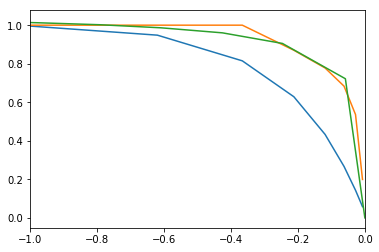

In [14]:
plt.plot(-dp[0], accu_fr_mean[:,4])
plt.plot(-dp[0], accu_fr_mean_new[:,4])
plt.plot(obs_dp, accu_fr_obs)

plt.xlim([-1, 0])

In [78]:
# Examine the vertical SOC stock over the study area
fpath='/global/cscratch1/sd/sshu3/SBGC/data/'
fsoilc='Global_1DSBGC.bgc-yearly-3d_11900.nc'
varname_soilc='soil_c_lev'
# Read in soilc
fp=fpath+fsoilc
nclu=NetCDFFile(fp,'r')
soilc_lev = nclu.variables[varname_soilc][:]
nclu.close()

# Calculate Earth's area
# Area of each grid
grid_area = np.zeros((nlat, nlon))
EARTH_AREA = 5.096e14
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5

for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (EARTH_AREA/2)*abs(np.sin((lat[i] - res/2)*math.pi/180) -
                np.sin((lat[i] + res/2)*math.pi/180))/(360/res)

totsoilc = np.zeros((10))
for i in np.arange(10):
    soilc_lev[i,:,:] = soilc_lev[i,:,:]*grid_area
    totsoilc[i] = np.nansum(soilc_lev[i,:,:])/1e12

In [80]:
totsoilc

array([  31.71021416,   31.05277805,   34.85970801,   48.49331746,
         68.36986355,   97.14130192,  138.29090895,  139.35125729,
         47.58606545,    1.69532103])

In [81]:
np.sum(totsoilc[0:6])

311.62718314587516

In [27]:
# Check Turnover time for 8 pools
nlon=720
nlat=360
fpath='/global/cscratch1/sd/sshu3/trendy_SG0/output/'
fid1='to1_out.nc'
fid2='to2_out.nc'
fid3='to3_out.nc'
fid4='to4_out.nc'
fid5='to5_out.nc'
fid6='to6_out.nc'
fid7='to7_out.nc'
fid8='to8_out.nc'

# Open file and get data
fp=fpath+fid1
nclu=NetCDFFile(fp,'r')
to1 = nclu.variables['to1'][:]
soc1 = nclu.variables['soilc_pool1'][:]
nclu.close()

fp=fpath+fid2
nclu=NetCDFFile(fp,'r')
to2 = nclu.variables['to2'][:]
soc2 = nclu.variables['soilc_pool2'][:]
nclu.close()

fp=fpath+fid3
nclu=NetCDFFile(fp,'r')
to3 = nclu.variables['to3'][:]
soc3 = nclu.variables['soilc_pool3'][:]
nclu.close()

fp=fpath+fid4
nclu=NetCDFFile(fp,'r')
to4 = nclu.variables['to4'][:]
soc4 = nclu.variables['soilc_pool4'][:]
nclu.close()

fp=fpath+fid5
nclu=NetCDFFile(fp,'r')
to5 = nclu.variables['to5'][:]
soc5 = nclu.variables['soilc_pool5'][:]
nclu.close()

fp=fpath+fid6
nclu=NetCDFFile(fp,'r')
to6 = nclu.variables['to6'][:]
soc6 = nclu.variables['soilc_pool6'][:]
nclu.close()

fp=fpath+fid7
nclu=NetCDFFile(fp,'r')
to7 = nclu.variables['to7'][:]
soc7 = nclu.variables['soilc_pool7'][:]
nclu.close()

fp=fpath+fid8
nclu=NetCDFFile(fp,'r')
to8 = nclu.variables['to8'][:]
soc8 = nclu.variables['soilc_pool8'][:]
nclu.close()

# Calculate the global mean
to1[to1>10000] = np.float('nan')
to2[to2>10000] = np.float('nan')
to3[to3>10000] = np.float('nan')
to4[to4>10000] = np.float('nan')
to5[to5>10000] = np.float('nan')
to6[to6>10000] = np.float('nan')
to7[to7>10000] = np.float('nan')
to8[to8>10000] = np.float('nan')
to1[to1<=0] = np.float('nan')
to2[to2<=0] = np.float('nan')
to3[to3<=0] = np.float('nan')
to4[to4<=0] = np.float('nan')
to5[to5<=0] = np.float('nan')
to6[to6<=0] = np.float('nan')
to7[to7<=0] = np.float('nan')
to8[to8<=0] = np.float('nan')

# Global area
# Area of each grid
grid_area = np.zeros((nlon, nlat))
EARTH_AREA = 5.096e14
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5

for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[j,i] = (EARTH_AREA/2)*abs(np.sin((lat[i] - res/2)*math.pi/180) -
                np.sin((lat[i] + res/2)*math.pi/180))/(360/res)
grid_area_t = np.transpose(grid_area)

# Multiply
grid_area_c = copy.deepcopy(grid_area_t)
grid_area_c[np.isnan(to1)] = np.float('nan')
soc1[np.isnan(to1)] = np.float('nan')
grid_a = np.nansum(grid_area_c*soc1)
to1_a = np.nansum(grid_area_c*soc1*to1)
to1_globe = to1_a/grid_a

grid_area_c = copy.deepcopy(grid_area_t)
grid_area_c[np.isnan(to2)] = np.float('nan')
soc2[np.isnan(to2)] = np.float('nan')
grid_a = np.nansum(grid_area_c*soc2)
to2_a = np.nansum(grid_area_c*soc2*to2)
to2_globe = to2_a/grid_a

grid_area_c = copy.deepcopy(grid_area_t)
grid_area_c[np.isnan(to3)] = np.float('nan')
soc3[np.isnan(to3)] = np.float('nan')
grid_a = np.nansum(grid_area_c*soc3)
to3_a = np.nansum(grid_area_c*soc3*to3)
to3_globe = to3_a/grid_a

grid_area_c = copy.deepcopy(grid_area_t)
grid_area_c[np.isnan(to4)] = np.float('nan')
soc4[np.isnan(to4)] = np.float('nan')
grid_a = np.nansum(grid_area_c*soc4)
to4_a = np.nansum(grid_area_c*soc4*to4)
to4_globe = to4_a/grid_a

grid_area_c = copy.deepcopy(grid_area_t)
grid_area_c[np.isnan(to5)] = np.float('nan')
soc5[np.isnan(to5)] = np.float('nan')
grid_a = np.nansum(grid_area_c*soc5)
to5_a = np.nansum(grid_area_c*soc5*to5)
to5_globe = to5_a/grid_a

grid_area_c = copy.deepcopy(grid_area_t)
grid_area_c[np.isnan(to6)] = np.float('nan')
soc6[np.isnan(to6)] = np.float('nan')
grid_a = np.nansum(grid_area_c*soc6)
to6_a = np.nansum(grid_area_c*soc6*to6)
to6_globe = to6_a/grid_a

grid_area_c = copy.deepcopy(grid_area_t)
grid_area_c[np.isnan(to7)] = np.float('nan')
soc7[np.isnan(to7)] = np.float('nan')
grid_a = np.nansum(grid_area_c*soc7)
to7_a = np.nansum(grid_area_c*soc7*to7)
to7_globe = to7_a/grid_a

grid_area_c = copy.deepcopy(grid_area_t)
grid_area_c[np.isnan(to8)] = np.float('nan')
soc8[np.isnan(to8)] = np.float('nan')
grid_a = np.nansum(grid_area_c*soc8)
to8_a = np.nansum(grid_area_c*soc8*to8)
to8_globe = to8_a/grid_a

/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in greater
/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater
/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in greater
/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in greater
/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in greater
/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in greater
/global/common/cori/software/python/2.7-

In [53]:
to7_globe

4.6512885622763411